In [1]:
import pandas as pd
import numpy as np
import sys
import math
import matplotlib.pyplot as plt
%matplotlib inline


Regularization methods are those which reduce generalization error.
- L1 and L2 regularization are used to calculate a number (called a penalty) added to the loss value to penalize the model for large weights and biases. Large weights might indicate that a neuron is attempting to memorize a data element; generally, it is believed that it would be better to have many neurons contributing to a model’s output, rather than a select few.

In [2]:
class Layer_Dense:
    def __init__(self, 
                 n_inputs,
                 n_neurons,
                 weight_regularizer_l1=0, 
                 weight_regularizer_l2=0,
                 bias_regularizer_l1=0, 
                 bias_regularizer_l2=0):
        
        self.weights = 0.01*np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2
        
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
        
    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        
        # L1 on weights
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1
        # L2 on weights
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * self.weights
        # L1 on biases
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1
        # L2 on biases
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * self.biases
        
        
        self.dinputs = np.dot(dvalues, self.weights.T)
        

In [3]:
class Activation_ReLu:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
        
        
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

In [4]:
class Activation_Softmax:
    def forward(self, inputs):
        self.inputs = inputs
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities
    
    def backward(self, dvalues):
        self.dinputs = np.empty_like(dvalues)
        
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            single_output = single_output.reshape(-1,1)
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)


In [5]:
class Activation_Sigmoid:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = 1/(1+np.exp(-inputs))
        
    def backward(self, dvalues):
        self.dinputs = dvalues * (1-self.output) * self.output
        

In [6]:
class Optimizer_SGD:
    def __init__(self, learning_rate=1.0, decay=0.0, momentum=0.0):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay 
        self.iterations = 0
        self.momentum = momentum
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = (self.learning_rate * 
                                           (1. / (1. + self.decay * self.iterations)))
        
    def update_params(self, layer):
        if self.momentum:
            
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)
            
            # Build weight updates with momentum
            weight_updates = (self.momentum * layer.weight_momentums - 
                            self.current_learning_rate * layer.dweights 
                            )
            layer.weight_momentums = weight_updates
            # Build bias updates      
            bias_updates = (self.momentum * layer.bias_momentums - 
                            self.current_learning_rate * layer.dbiases
                            )
            layer.bias_momentums = bias_updates
            
        else: 
            # Same as before adding momentum (check Spiral_Data.ipynb)
            weight_updates = -self.learning_rate * layer.dweights
            bias_updates += -self.learning_rate * layer.dbiases

        #Update the weights and biases
        layer.weights += weight_updates
        layer.biases += bias_updates
          
    def post_update_params(self):
        self.iterations += 1

In [7]:

class Optimizer_Adagrad:
    def __init__(self, learning_rate=1.0, decay=0.0, epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay 
        self.iterations = 0
        self.epsilon = epsilon
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = (self.learning_rate * 
                                           (1. / (1. + self.decay * self.iterations)))
        
    def update_params(self, layer):
        if not hasattr(layer, 'weight_momentums'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
        
        # Update cache with squared current gradients
        layer.weight_cache += layer.dweights**2
        layer.bias_cache += layer.dbiases**2
        
        layer.weights += (-self.learning_rate * layer.dweights /
                          (np.sqrt(layer.weight_cache) + self.epsilon)
                        )
        layer.biases += (-self.learning_rate * layer.dbiases /
                          (np.sqrt(layer.bias_cache) + self.epsilon)
                        )
          
    def post_update_params(self):
        self.iterations += 1

In [8]:
class Optimizer_RMSprop:
    def __init__(self, 
                learning_rate=0.001, 
                decay=0.0, 
                epsilon=1e-7,
                rho=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho
    
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = (self.learning_rate * 
                                          (1.0 /(1.0 + self.decay * self.iterations)))
    
    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
        
        layer.weight_cache = (self.rho * layer.weight_cache +
                              (1.0 - self.rho) * layer.dweights**2)
        layer.bias_cache = (self.rho * layer.bias_cache +
                              (1.0 - self.rho) * layer.dbiases**2)
        
        layer.weights += (-self.current_learning_rate * 
                           layer.dweights / 
                           (np.sqrt(layer.weight_cache) + self.epsilon))
        
        layer.biases += (-self.current_learning_rate * 
                           layer.dbiases / 
                           (np.sqrt(layer.bias_cache) + self.epsilon))

    def post_update_params(self):
        self.iterations += 1
    

In [9]:
class Optimizer_Adam:
    def __init__(self,
                 learning_rate=0.001,
                 decay=0.0,
                 epsilon=1e-7,
                 beta_1=0.9,
                 beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        
    def pre_update_params(self): 
        if self.decay:
            self.current_learning_rate = (self.learning_rate * 
                                          (1.0 / (1.0 + self.decay * self.iterations)))
    
    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)
        # Update momentum  with current gradients
        layer.weight_momentums = (self.beta_1 * layer.weight_momentums +
                                  (1.0 - self.beta_1) * layer.dweights)
        layer.bias_momentums = (self.beta_1 * layer.bias_momentums +
                                  (1.0 - self.beta_1) * layer.dbiases)
        # Get corrected momentum
        weight_momentums_corrected = (layer.weight_momentums / 
                                      (1 - self.beta_1 ** (self.iterations + 1)))
        bias_momentums_corrected = (layer.bias_momentums / 
                                    (1 - self.beta_1 ** (self.iterations + 1)))
        
        # Update cache with squared current gradients
        layer.weight_cache = (self.beta_2 * layer.weight_cache + 
                              (1 - self.beta_2) * layer.dweights**2)
        layer.bias_cache = (self.beta_2 * layer.bias_cache + 
                              (1 - self.beta_2) * layer.dbiases**2)
        
        weight_cache_corrected = (layer.weight_cache / 
                                  (1-self.beta_2**(self.iterations +1)))
        bias_cache_corrected = (layer.bias_cache / 
                                  (1-self.beta_2**(self.iterations +1)))
        
        layer.weights += (-self.current_learning_rate * 
                           weight_momentums_corrected / 
                           (np.sqrt(weight_cache_corrected) +
                               self.epsilon))
        layer.biases += (-self.current_learning_rate * 
                           bias_momentums_corrected / 
                           (np.sqrt(bias_cache_corrected) +
                               self.epsilon))
        
    def post_update_params(self):
        self.iterations += 1
        


In [10]:
class Loss:
    def regularization_loss(self, layer):
        regularization_loss = 0
        if layer.weight_regularizer_l1 > 0:
            regularization_loss += (layer.weight_regularizer_l1 *
                                    np.sum(np.abs(layer.weights)))
        if layer.weight_regularizer_l2 > 0:
            regularization_loss += (layer.weight_regularizer_l2 * 
                                    np.sum(layer.weights * layer.weights))
        if layer.bias_regularizer_l1 > 0:
            regularization_loss += (layer.bias_regularizer_l1 * 
                                    np.sum(np.abs(layer.biases)))
        if layer.bias_regularizer_l2 > 0:
            regularization_loss += (layer.bias_regularizer_l2 * 
                                    np.sum(layer.biases * layer.biases))
        return regularization_loss
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss

In [11]:
class Loss_CategoricalCrossentropy(Loss):
    def regularization_loss(self, layer):
        regularization_loss = 0
        if layer.weight_regularizer_l1 > 0:
            regularization_loss += (layer.weight_regularizer_l1 *
                                    np.sum(np.abs(layer.weights)))
        if layer.weight_regularizer_l2 > 0:
            regularization_loss += (layer.weight_regularizer_l2 * 
                                    np.sum(layer.weights * layer.weights))
        if layer.bias_regularizer_l1 > 0:
            regularization_loss += (layer.bias_regularizer_l1 * 
                                    np.sum(np.abs(layer.biases)))
        if layer.bias_regularizer_l2 > 0:
            regularization_loss += (layer.bias_regularizer_l2 * 
                                    np.sum(layer.biases * layer.biases))
        return regularization_loss
    
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)
        
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
        
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped*y_true, axis=1)
        
        negative_log_likelihood = -np.log(correct_confidences)
        return negative_log_likelihood
    
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        labels = len(dvalues[0])
        
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
        
        self.dinputs = -y_true / dvalues
        self.dinputs = self.dinputs/samples

In [12]:
class Loss_BinaryCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)
        sample_losses = -(y_true * np.log(y_pred_clipped) + 
                          (1-y_true) * np.log(1 - y_pred_clipped))
        sample_losses = np.mean(sample_losses, axis=-1)
        
        return sample_losses
    
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        
        clipped_dvalues = np.clip(dvalues, 1e-7, 1-1e-7)
        
        self.dinputs = -(y_true / clipped_dvalues -
                         (1-y_true) / (1-clipped_dvalues)) / outputs
        self.dinputs = self.dinputs / samples
    

In [13]:
class Activation_Softmax_Loss_CategoricalCrossentropy():
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()
        
    def forward(self, inputs, y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output
        return self.loss.calculate(self.output, y_true)

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        
        self.dinputs = dvalues.copy()
        self.dinputs[range(samples), y_true] -= 1
        self.dinputs = self.dinputs/ samples

In [14]:
class Layer_Dropout:
    def __init(self, rate):
        self.rate = 1- rate
    
    def forward(self, inputs):
        self.inputs = inputs 
        self.binary_mask = np.random.binomial(1, self.rate, size=inputs.shape) / self.rate
        self.output = inputs * self.binary_mask
        
    def backward(self, dvalues):
        self.dinputs = dvalues * self.binary_mask


In [15]:
def spiral_data(points, classes):
    X = np.zeros((points*classes, 2))
    y = np.zeros(points*classes, dtype='uint8')
    for class_number in range(classes):
        ix = range(points*class_number, points*(class_number+1))
        r = np.linspace(0.0, 1, points)  # radius
        t = np.linspace(class_number*4, (class_number+1)*4, points) + np.random.randn(points)*0.2
        X[ix] = np.c_[r*np.sin(t*2.5), r*np.cos(t*2.5)]
        y[ix] = class_number
    return X, y

# Binary Logistic Regression
A model with this type of output layer is called binary logistic regression. This single neuron could represent two classes like cat vs. dog, but it could also represent cat vs. not cat or any combination of 2 classes, and you could have many of these


In [19]:

X, y = spiral_data(points=100, classes=2)
y = y.reshape(-1,1)
dense1 = Layer_Dense(2, 64, weight_regularizer_l2=5e-4, 
                            bias_regularizer_l2=5e-4)
activation1 = Activation_ReLu()
dense2 = Layer_Dense(64, 1)
activation2 = Activation_Sigmoid()

#loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
loss_function = Loss_BinaryCrossentropy()
optimizer = Optimizer_Adam(learning_rate=0.02, decay=5e-7) # Train in loop

for epoch in range(10001):
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    
    data_loss = loss_function.forward(activation2.output, y)
    #regularization_loss = (loss_activation.loss.regularization_loss(dense1) + 
    #                       loss_activation.loss.regularization_loss(dense2))
    regularization_loss = (loss_function.regularization_loss(dense1) +
                        loss_function.regularization_loss(dense2))
    loss = data_loss + regularization_loss

    #predictions = np.argmax(loss_activation.output, axis=1)
    predictions = (activation2.output > 0.5) * 1
    accuracy = np.mean(predictions == y)

    #if len(y.shape) == 2:
    #    y = np.argmax(y, axis=1) 
    #accuracy = np.mean(predictions == y)

    if not epoch % 100: print(f'epoch: {epoch}, ' +
        f'acc: {accuracy:.3f}, ' +
        #f'loss: {loss:.3f} (' +
        #f'data_loss: {data_loss:.3f}, ' + 
        #f'reg_loss: {regularization_loss:.3f}), ' + 
        f'lr: {optimizer.current_learning_rate}')

    #loss_activation.backward(loss_activation.output, y)
    loss_function.backward(activation2.output, y)
    activation2.backward(loss_function.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

# Validate 
X_test, y_test = spiral_data(100, 2)
y_test = y_test.reshape(-1, 1)

dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)

#loss = loss_activation.forward(dense2.output, y_test)
loss = loss_function.calculate(activation2.output, y_test)

predictions = (activation2.output > 0.5) * 1
#if len(y_test.shape) == 2:
#    y_test = np.argmax(y_test, axis=1) 
#accuracy = np.mean(predictions == y_test)
accuracy = np.mean(predictions == y_test)
print(f'validation, acc: {accuracy:.3f}, loss: {loss:.3f}')


epoch: 0, acc: 0.500, lr: 0.02
epoch: 100, acc: 0.800, lr: 0.019999010049002574
epoch: 200, acc: 0.845, lr: 0.019998010197985302
epoch: 300, acc: 0.860, lr: 0.019997010446938183
epoch: 400, acc: 0.900, lr: 0.01999601079584623
epoch: 500, acc: 0.900, lr: 0.01999501124469445
epoch: 600, acc: 0.875, lr: 0.01999401179346786
epoch: 700, acc: 0.895, lr: 0.01999301244215147
epoch: 800, acc: 0.900, lr: 0.0199920131907303
epoch: 900, acc: 0.890, lr: 0.019991014039189386
epoch: 1000, acc: 0.890, lr: 0.019990014987513734
epoch: 1100, acc: 0.910, lr: 0.01998901603568839
epoch: 1200, acc: 0.890, lr: 0.019988017183698373
epoch: 1300, acc: 0.895, lr: 0.01998701843152872
epoch: 1400, acc: 0.900, lr: 0.019986019779164473
epoch: 1500, acc: 0.895, lr: 0.019985021226590672
epoch: 1600, acc: 0.900, lr: 0.01998402277379235
epoch: 1700, acc: 0.915, lr: 0.01998302442075457
epoch: 1800, acc: 0.900, lr: 0.019982026167462367
epoch: 1900, acc: 0.915, lr: 0.019981028013900805
epoch: 2000, acc: 0.920, lr: 0.0199800

# Regression
## Mean Squared Error (MSE)
- L = (1/J)sum(yi-yi_hat)^2
- L' = (-2/J)(yi-yi_hat)^2

## Mean Absolute Error (MAE)
- L = 1/Jsum(abs(yi-yi_hat))
- something ugly 

#### MSE better than MAE

In [20]:
class Activation_Linear:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = inputs
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        

In [21]:

class Loss_MeanSquaredError(Loss):
    def forward(self, y_pred, y_true):
        sample_losses = np.mean((y_true - y_pred)**2, axis=-1)
        return sample_losses
    
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        
        self.dinputs = -2*(y_true-dvalues)/outputs
        self.dinputs = self.dinputs/samples
        
class Loss_MeanAbsoluteError(Loss):
    def forward(self, y_pred, y_true):
        sample_losses = np.mean(np.abs(y_true - y_pred), axis=-1)
        return sample_losses

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        self.dinputs = np.sign(y_true-dvalues)/outputs
        self.dinputs = self.dinputs / samples
        
    


In [22]:
import matplotlib.pyplot as plt
import nnfs
from nnfs.datasets import sine_data
nnfs.init()
X, y = sine_data()


In [23]:

dense1 = Layer_Dense(1, 64)
activation1 = Activation_ReLu()
dense2 = Layer_Dense(64, 64)
activation2 = Activation_ReLu()
dense3 = Layer_Dense(64, 1)
activation3 = Activation_Linear()
loss_function = Loss_MeanSquaredError()
optimizer = Optimizer_Adam()

accuracy_precision = np.std(y) / 250 #Range of what we define as accurate
# Train in loop
for epoch in range(10001):
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    dense3.forward(activation2.output)
    activation3.forward(dense3.output)
    
    data_loss = loss_function.calculate(activation3.output, y)
    
    regularization_loss = (loss_function.regularization_loss(dense1) +
                           loss_function.regularization_loss(dense2) +
                           loss_function.regularization_loss(dense3))
    loss = data_loss + regularization_loss
    
    predictions = activation3.output
    accuracy = np.mean(np.absolute(predictions - y) < accuracy_precision)
    
    if not epoch % 100: 
        print(f'epoch: {epoch}, ' +
        f'acc: {accuracy:.3f}, ' +
        f'loss: {loss:.3f} (' +
        f'data_loss: {data_loss:.3f},' +
        f'reg_loss: {regularization_loss:.3f}), ' + 
        f'lr: {optimizer.current_learning_rate}')
        # Backward pass
        loss_function.backward(activation3.output, y)
        activation3.backward(loss_function.dinputs)
        dense3.backward(activation3.dinputs)
        activation2.backward(loss_function.dinputs)
        dense2.backward(activation2.dinputs)
        activation1.backward(dense2.dinputs)
        dense1.backward(activation1.dinputs)
        # Update weights and biases
        optimizer.pre_update_params()
        optimizer.update_params(dense1)
        optimizer.update_params(dense2)
        optimizer.update_params(dense3)
        optimizer.post_update_params()
    
    

epoch: 0, acc: 0.002, loss: 0.500 (data_loss: 0.500,reg_loss: 0.000), lr: 0.001


IndexError: boolean index did not match indexed array along dimension 1; dimension is 1 but corresponding boolean dimension is 64

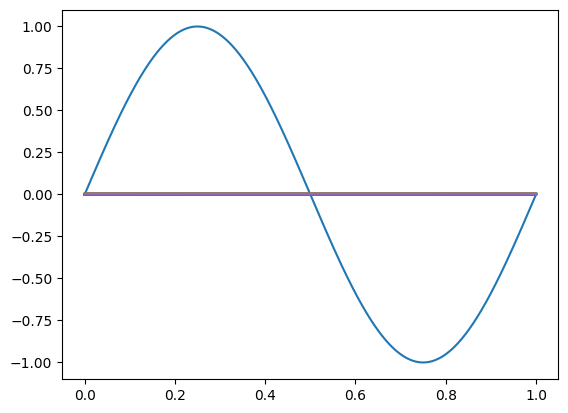

In [24]:

X_test, y_test = sine_data()
dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
plt.plot(X_test, y_test)
plt.plot(X_test, activation2.output)


<IPython.core.display.Javascript object>

array([[<AxesSubplot: title={'center': '0'}>]], dtype=object)